# ***House Prices: Advanced Regression Techniques¶***

![House Image](https://media.istockphoto.com/id/1450257988/vector/housing-price-rising-up.jpg?s=612x612&w=0&k=20&c=ZX2RDOCJL3FHMjgirJXE68oOfA6jp5iZNhAP8_QA3ik=)

# ***Table of Content***
***1. About the Dataset***\
***2. Import Libraries***\
***3. Data Exploration & Visualization***\
***4. Data Preprocessing***\
***5. Model Building***\
***6. Conclussions***

# ***1. About the Dataset***


*`Title`*: ***House Price Prediction - Advanced Regression Techniques***

*`Context`*: *This dataset challenges participants to predict house prices in Ames, Iowa using 79 diverse explanatory variables. It demonstrates that factors beyond typical considerations like bedroom count significantly influence home prices. The competition aims to uncover the complex interplay of features affecting residential property values.*

*`Project Goal`*
- *Predict house sale prices based on given features*
- *Each dataset row represents a house with its characteristics*
- *Evaluation metric: Root-Mean-Squared-Error (RMSE) of log(predicted price) vs log(actual price)*
- *Log-scale RMSE ensures equal weight for errors in expensive and inexpensive houses*

# ***2. Import Libraries***

In [1]:
# Import necessary libraries

# System and utility libraries
import os
import warnings
from datetime import datetime

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and machine learning libraries
## Core libraries
from scipy import stats
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

## Preprocessing
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

## Machine learning models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Dimensionality reduction and clustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Suppress warnings
warnings.filterwarnings('ignore')

# List input files
print("Input files:\n")
for file in os.listdir("./input"):
    print(file)

Input files:



data_description.txt

sample_submission.csv

test.csv

train.csv


# ***3. Data Exploration***

> ***Load the Dataset***

In [2]:
# submission data
df_submission = pd.read_csv("./input/sample_submission.csv")

# train data
df_train = pd.read_csv('./input/train.csv')

# test data
df_test = pd.read_csv('./input/test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


> ***Checking the number of rows and columns***


In [4]:
# checking the number of rows and columns
num_train_rows, num_train_columns = df_train.shape
num_test_rows, num_test_columns = df_test.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

Training Data:

Number of Rows: 1460

Number of Columns: 81



Test Data:

Number of Rows: 1459

Number of Columns: 80




> ***Variable Categorization***

- *Our dataset contains 81 attributes (including Id and SalePrice)*
- *36 quantitative variables*
- *43 categorical variables*

In [5]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

> ***Checking for null values***

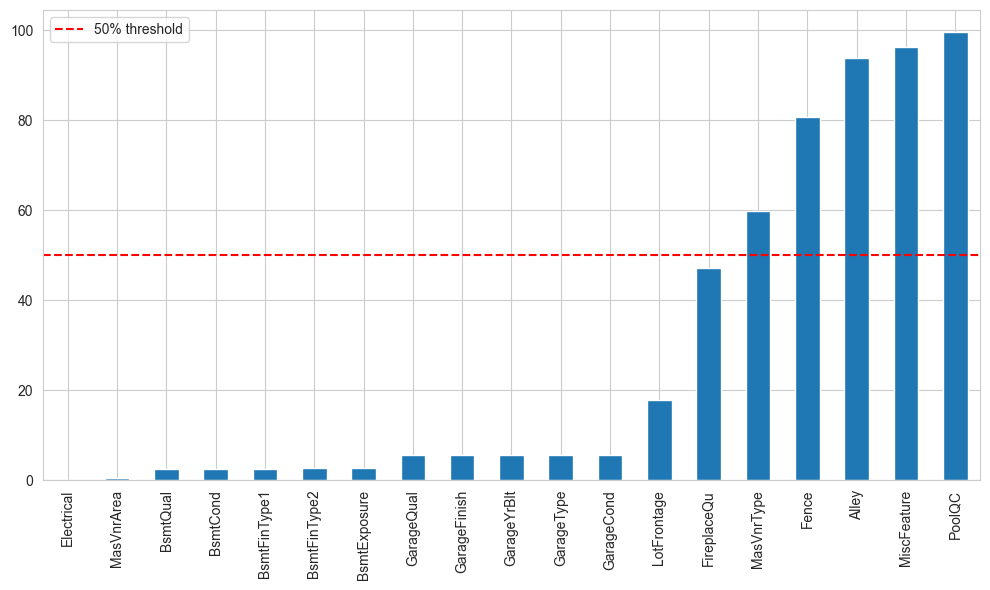

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  # Set figure size to 12x6 inches
missing = (df_train.isnull().sum() / len(df_train) * 100).sort_values()
missing = missing[missing > 0]
ax = missing.plot.bar()
ax.axhline(y=50, color='r', linestyle='--', label='50% threshold')
ax.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

***Missing Values Analysis:***
- *19 attributes have missing values*
- *5 attributes have over 50% missing data*
- *In most cases, NA likely indicates absence of the feature: No pool, No fence, No garage, No basement*

*This suggests that missing values often represent meaningful information*
*about the property, rather than just incomplete data.*

> ***Checking for duplicate values***

In [7]:
# Check for duplicate values
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("\nDuplicate rows:")
    print(df_train[df_train.duplicated(keep=False)])
else:
    print("No duplicate rows found in the dataset.")

Number of duplicate rows: 0

No duplicate rows found in the dataset.


> ***SalesPrice Distribution Analysis***

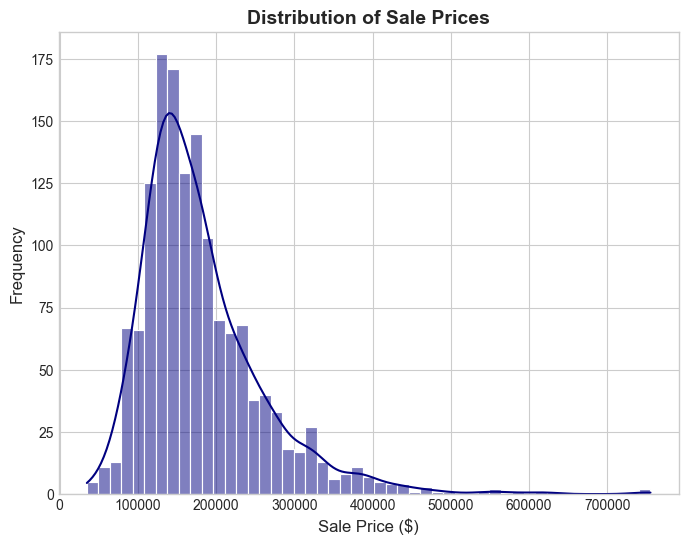

In [8]:
# Plot SalesPrice distribution
plt.style.use('seaborn-whitegrid')
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=df_train, x='SalePrice', kde=True, color='navy', ax=ax)
ax.set_xlabel('Sale Price ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Sale Prices', fontsize=14, fontweight='bold')
plt.show()

*SalePrice is not normally distributed. It needs transformation before regression. Log transformation works well, but Johnson distribution provides the best fit.*

> ***Visualize some of the features in dataset***

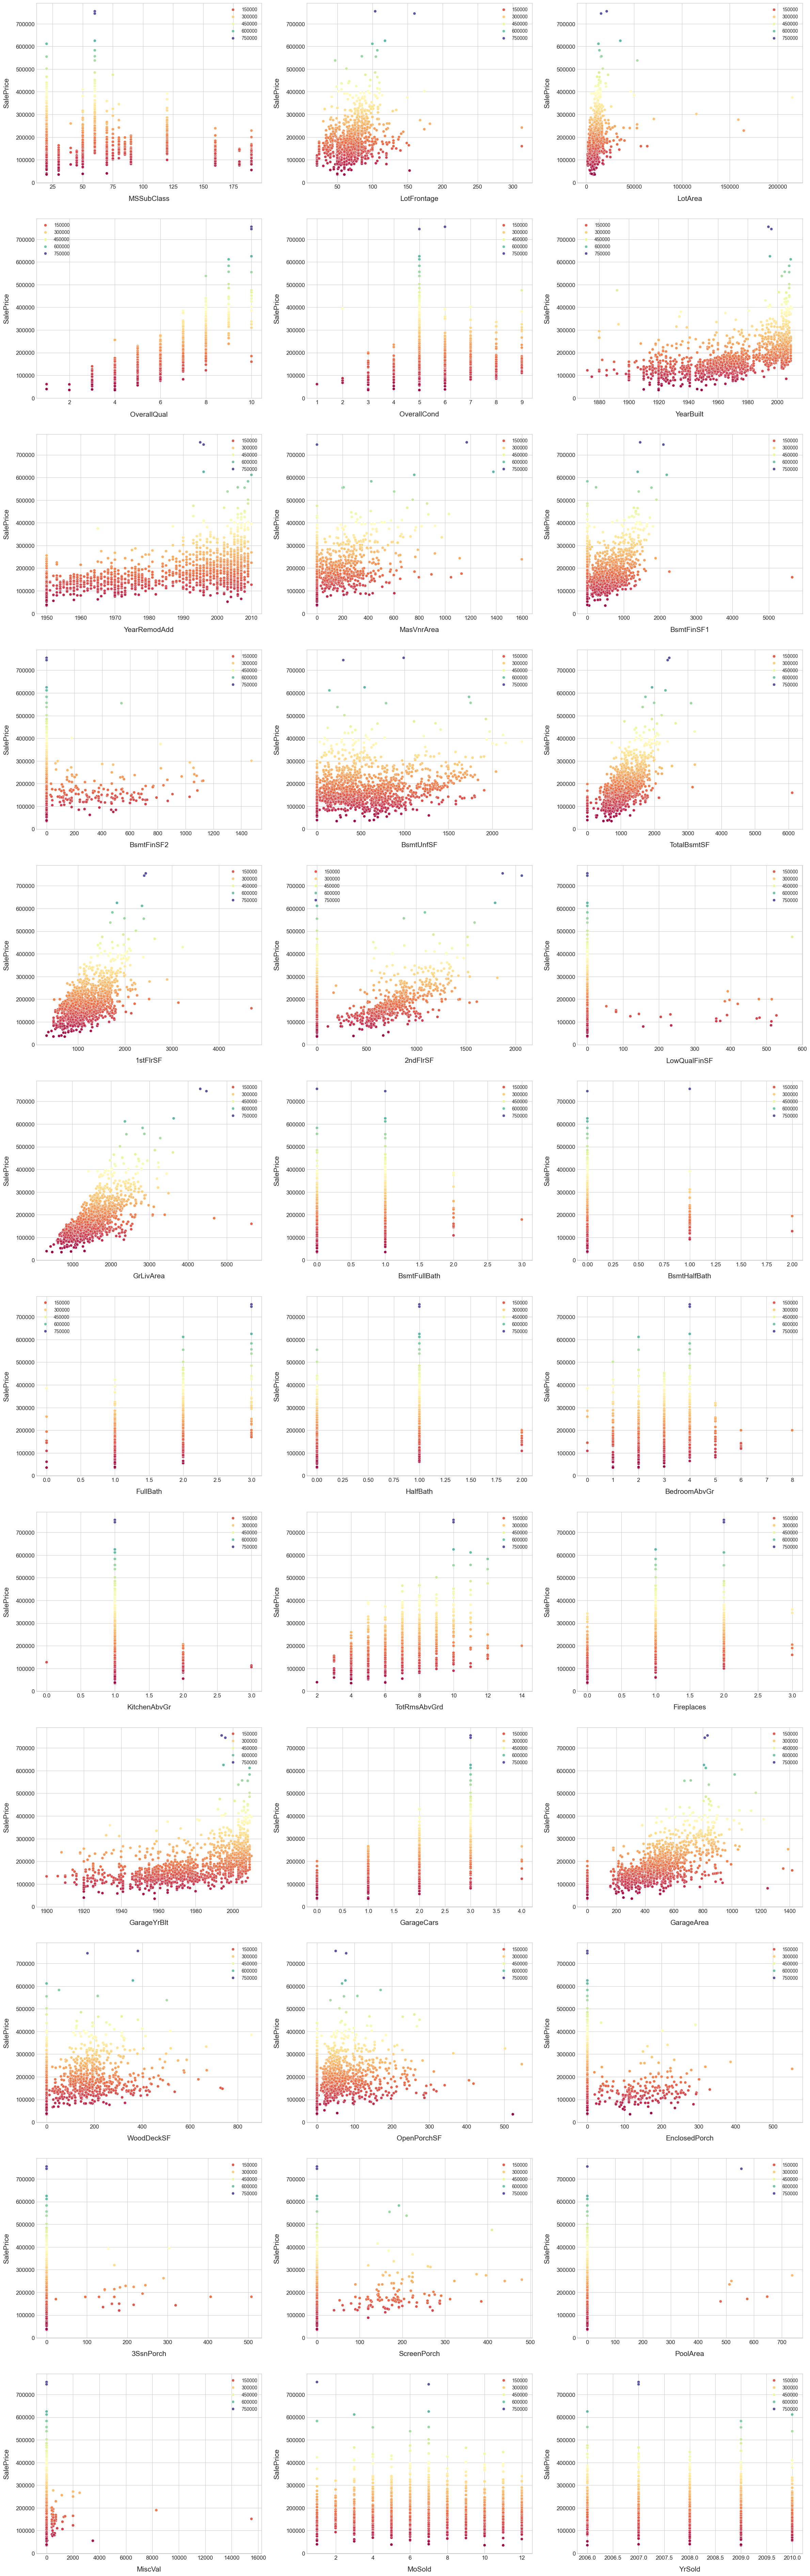

In [9]:
# Visualising Quantitative features in the dataset
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)

for i, feature in enumerate(list(quantitative), 1):
    plt.subplot(len(list(quantitative)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Spectral', data=df_train)
    
    plt.xlabel(f"{feature}", size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
        
    plt.legend(loc='best', prop={'size' : 10})

plt.show()

> ***Normality Test for Quantitative Variables***

In [10]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(df_train[quantitative])
normal = normal.apply(test_normality)
print("All normal" if not normal.any() else "Some not normal")

Some not normal


*Our analysis shows that all quantitative variables are non-normally distributed. We should transform these variables before further analysis or modeling to improve statistical reliability and model performance.*

> ***Ordinal Encoding of Qualitative Features Based on SalePrice Mean***

In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(df_train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


> ***Correlation Analysis: Numerical, Categorical, and Cross-Feature Relationships***

<Axes: >

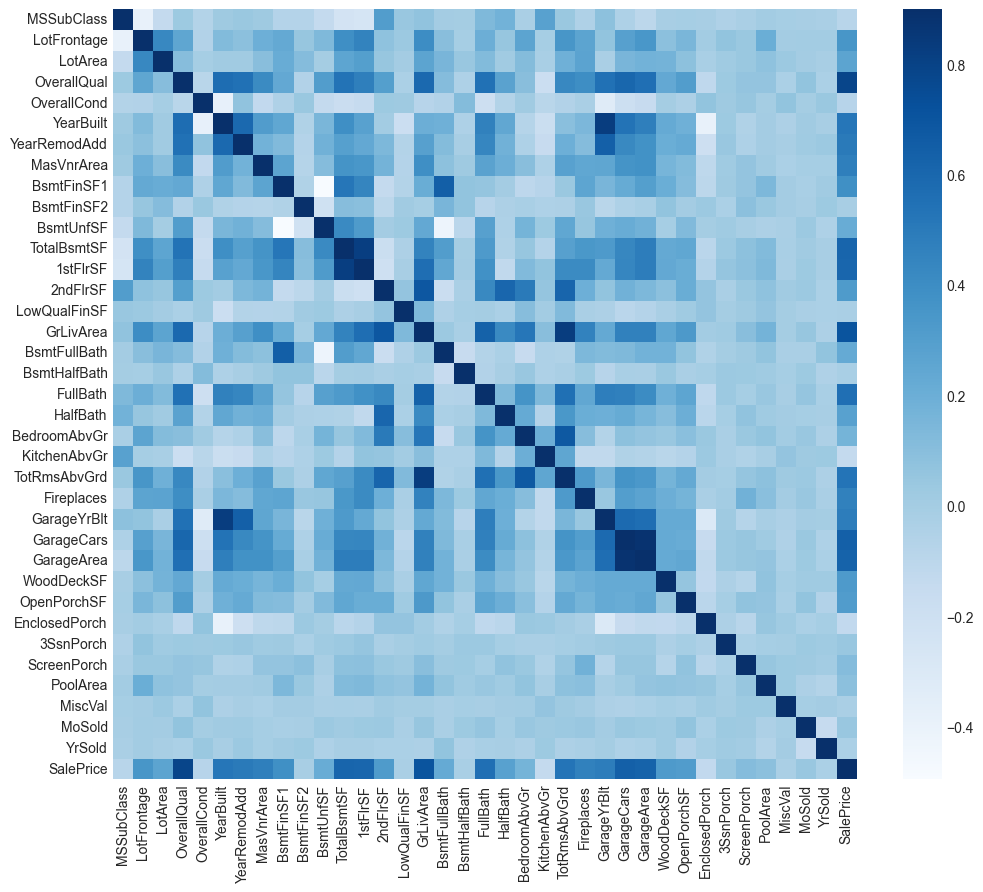

In [12]:
# quantitative
plt.figure(figsize=(12, 10))
corr = df_train[quantitative+['SalePrice']].corr()
sns.heatmap(corr, vmax=0.9, cmap="Blues")


<Axes: >

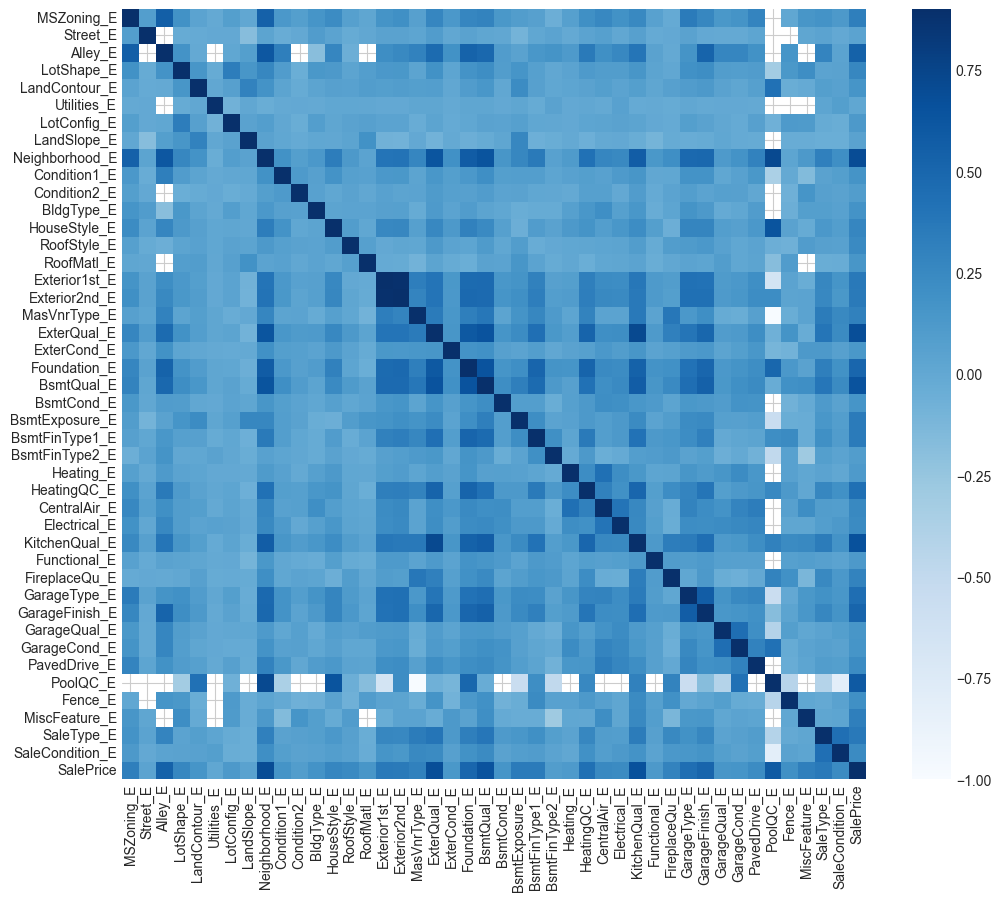

In [13]:
# qualitative
plt.figure(figsize=(12, 10))
corr = df_train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr, vmax=0.9, cmap="Blues")

<Axes: >

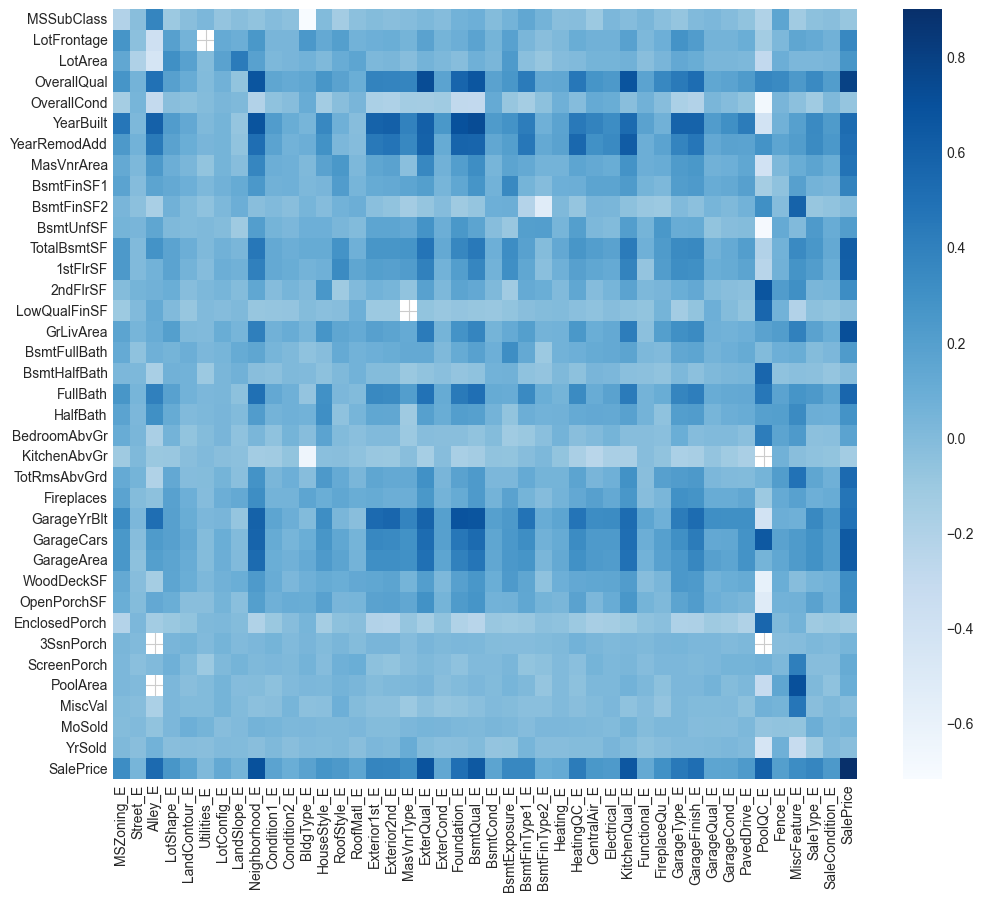

In [14]:
# cross feature relationship
plt.figure(figsize=(12, 10))
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = df_train[q1].corr(df_train[q2])
sns.heatmap(corr, vmax=0.9, cmap="Blues")

> ***Advanced Data Visualization and Clustering analysis***

0.7552858545295579


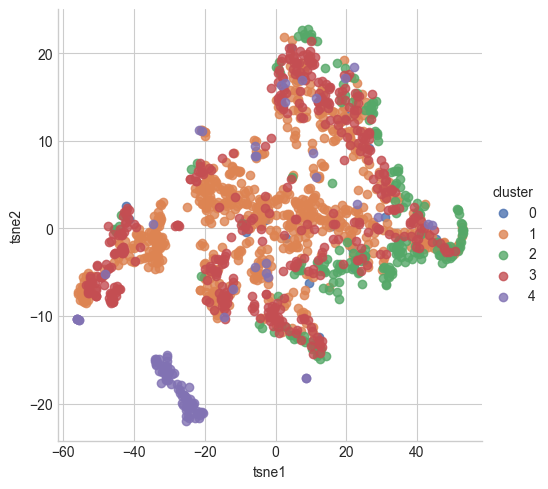

In [15]:
features = quantitative + qual_encoded
X = df_train[features].fillna(0.).values
model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

# ***4. Data Preprocessing***

> ***Removing id column from train and test dataset***

In [16]:
df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)

> ***Removing Outlier from GrLivArea***

In [17]:
df_train = df_train[df_train.GrLivArea < 4500]
df_train.reset_index(drop=True, inplace=True)

> ***Log-transform the SalePrice***

In [18]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

# Separate target variable
y = df_train['SalePrice'].reset_index(drop=True)

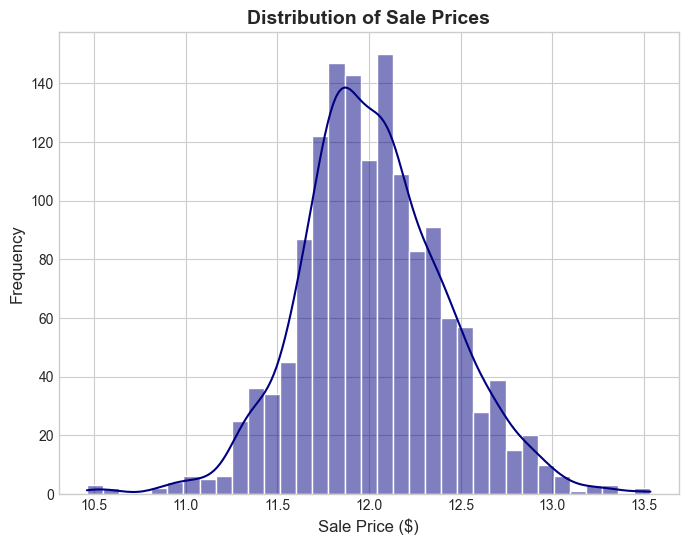

In [19]:
# Plot SalesPrice distribution
plt.style.use('seaborn-whitegrid')
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=df_train, x='SalePrice', kde=True, color='navy', ax=ax)
ax.set_xlabel('Sale Price ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Sale Prices', fontsize=14, fontweight='bold')
plt.show()

***The log transformation has successfully normalized the SalePrice distribution, enhancing our model's performance and reliability***.

> ***Combined Feature Set for Preprocessing***

In [20]:
train_features = df_train.drop(['SalePrice'], axis=1)
test_features = df_test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [21]:
features.shape

(2917, 122)

> ***Type Conversion***

In [22]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

> ***Missing Value Imputation***

In [23]:
# Fill specific categorical features
categorical_fills = {
    'Functional': 'Typ',
    'Electrical': 'SBrkr',
    'KitchenQual': 'TA',
    'PoolQC': 'None',
    'Exterior1st': features['Exterior1st'].mode()[0],
    'Exterior2nd': features['Exterior2nd'].mode()[0],
    'SaleType': features['SaleType'].mode()[0]
}
features = features.fillna(categorical_fills)

# Fill numeric garage features with 0
features[['GarageYrBlt', 'GarageArea', 'GarageCars']] = features[['GarageYrBlt', 'GarageArea', 'GarageCars']].fillna(0)

# Fill categorical garage and basement features with 'None'
garage_basement_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
features[garage_basement_cols] = features[garage_basement_cols].fillna('None')

# Fill MSZoning based on MSSubClass mode
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Fill remaining categorical columns with 'None' and numeric columns with 0
features = features.apply(lambda x: x.fillna('None') if x.dtype == 'object' else x.fillna(0))

# Special handling for LotFrontage
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

> ***Normalizing Skewed Numerical Features Using Power Transformation***

In [24]:
# Calculate skewness and identify highly skewed features
numeric_features = features.select_dtypes(include=['number']).columns
skew_features = features[numeric_features].apply(lambda x: stats.skew(x))
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)
features[skew_index] = pt.fit_transform(features[skew_index])

> ***Creating New Features***

In [25]:
# Let's supercharge our dataset with some awesome feature combos!
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [26]:
# Let's spice things up with some yes/no features!
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
features.shape

(2917, 132)

> ***Feature Encoding***

In [28]:
# One-Hot Encoding
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 385)

In [29]:
# Split the final_features into training (X) and submission (X_sub) datasets
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 385), (1458,), (1459, 385))

> ***Removing Outliers and Low Variance Features***

In [30]:
# Remove outliers
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

# Remove features with >99.94% zeros
overfit = [i for i in X.columns if X[i].value_counts().iloc[0] / len(X) * 100 > 99.94]
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [31]:
X.shape, y.shape, X_sub.shape

((1453, 383), (1453,), (1459, 383))

# ***5. Model Building***

> ***Cross Validation Setup***

In [32]:
# KFold Cross-Validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# RMSE Function
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Cross-Validation RMSE Function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [33]:
# Hyperparameter lists for different regression models
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

> ***Model Initialization***

In [34]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=int(1e7), alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=int(1e7), alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [35]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

In [36]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1)

In [37]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

> ***Stacking Model***

In [38]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

> ***Model Evaluation: Cross-Validation RMSE Scores***

In [39]:
# Evaluate and compare multiple regression models using cross-validation RMSE scores
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), "\n")

Ridge: 0.1025 (0.0143)

 2024-09-10 17:00:17.222657 



LASSO: 0.1018 (0.0154)

 2024-09-10 17:00:46.615059 



elastic net: 0.1019 (0.0153)

 2024-09-10 17:01:36.305736 



SVR: 0.1008 (0.0135)

 2024-09-10 17:01:39.291101 



lightgbm: 0.1066 (0.0155)

 2024-09-10 17:01:53.958810 



gbr: 0.1090 (0.0146)

 2024-09-10 17:03:33.270027 



xgboost: 0.1059 (0.0138)

 2024-09-10 17:04:28.529321 




> ***Model Training and Fitting***

In [40]:
# Model Fitting
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

stack_gen

elasticnet

Lasso

Ridge

Svr

GradientBoosting

xgboost

lightgbm


> ***Blending Model***

In [41]:
# Weighted ensemble of multiple regression models
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [42]:
print('RMSE score on train data:')
print(rmse(y, blend_models_predict(X)))

RMSE score on train data:

0.05388678006887687


> ***Create submission file***

In [43]:
# Predict using the blended model
blend_predictions = blend_models_predict(X_sub)
blend_predictions = np.expm1(blend_predictions)

# Create a submission DataFrame
submission = pd.DataFrame({
    'Id': df_submission['Id'],
    'SalePrice': blend_predictions
})

# Save the submission file
submission.to_csv("submission/blended_model_submission.csv", index=False)

# ***6. Conclusion***

*Our blended model approach, combining multiple regression techniques including Elastic Net, Lasso, Ridge, SVR, Gradient Boosting, XGBoost, LightGBM, and stacked models, has demonstrated robust performance in predicting house prices. The weighted ensemble leverages the strengths of each individual model, potentially mitigating their individual weaknesses.*

*The RMSE score on the training data indicates a good fit, suggesting that our model has captured significant patterns in the housing market data. However, it's important to note that the true test of our model's efficacy will be its performance on unseen data in the Kaggle competition.*

*This approach showcases the power of ensemble methods in tackling complex regression problems, particularly in the real estate domain where numerous factors influence property values. Future improvements could involve fine-tuning the model weights, exploring additional feature engineering, or incorporating more advanced techniques like neural networks.*
